In [1]:
import polars
import pandas as pd
import pathlib
import numpy as np
import scipy
import scanpy as sc
import matplotlib.pyplot as plt
import sklearn.manifold
import seaborn as sns

import utils
import plots

## Identify subset of variables of interest (protein coding genes)

In [3]:
utils.get_protein_coding_genes(
    file_path='../data/gencode.v26.annotation.gtf.gz', 
    save_path='../results/protein_coding_genes.csv',
    overwrite=False
)

File already exists and overwrite is False


## Identify subset of samples of interest (selected tissues)

In [6]:
sample_df_columns_description = pd.read_excel('../data/GTEx_Analysis_v8_Annotations_SampleAttributesDD.xlsx')
print(sample_df_columns_description[['VARNAME','COMMENT2']][:18].to_string())

      VARNAME                                                                                                             COMMENT2
0      SAMPID                                                                                                                  NaN
1    SMATSSCR                             The destruction of organism cells or tissues by the organisms’ own enzymes or processes.
2    SMNABTCH                                                          Batch when DNA/RNA was isolated and extracted from a sample
3   SMNABTCHT                                                                            The process by which DNA/RNA was isolated
4   SMNABTCHD                                                                               The date on which DNA/RNA was isolated
5    SMGEBTCH                                                                        Batch when DNA/RNA from a sample was analyzed
6   SMGEBTCHD                                                                      

SMTSD
Heart - Atrial Appendage    429
Heart - Left Ventricle      432
Kidney - Cortex              85
Kidney - Medulla              4
Liver                       226
Lung                        578
Muscle - Skeletal           803
Pancreas                    328
Pituitary                   283
Spleen                      241
Stomach                     359
Thyroid                     653
Name: count, dtype: int64

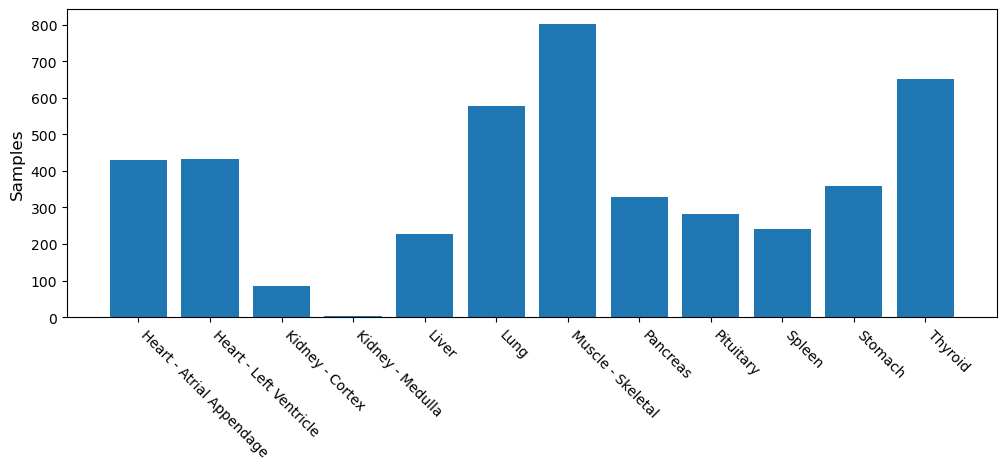

In [9]:
# load metadata
sample_df = pd.read_csv('../data/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt', sep='\t', index_col=0)
subject_df = pd.read_csv('../data/GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt', sep='\t', index_col=0)

# subset to RNA-seq 
selected_tissues = ['heart', 'kidney', 'liver', 'lung', 'muscle', 'pancreas', 'spleen', 'stomach', 'pituitary', 'thyroid']
rnaseq_sample_df = sample_df[sample_df['SMAFRZE']=='RNASEQ']

# subset RNA-seq to tissues of interest
selected_tissues_idx = rnaseq_sample_df['SMTSD'].str.contains('|'.join(selected_tissues),case=False)
rnaseq_sample_selected_tissues_df = rnaseq_sample_df[selected_tissues_idx].copy()

# add extra patient metadata columns and save
rnaseq_sample_selected_tissues_df['donor_ids'] = rnaseq_sample_selected_tissues_df.index.map(lambda x: '-'.join(x.split('-')[:2]))
df_ = rnaseq_sample_selected_tissues_df[['donor_ids']].reset_index().set_index('donor_ids').join(subject_df).set_index('SAMPID')
rnaseq_sample_selected_tissues_df = rnaseq_sample_selected_tissues_df.join(df_)

# grouping kidney tissue annotation (justified based on MDS plot analysis hereafter)
rnaseq_sample_selected_tissues_df['SMTSD_grouped'] = rnaseq_sample_selected_tissues_df['SMTSD']
rnaseq_sample_selected_tissues_df.loc[sample_df['SMTSD'].str.contains('Kidney'),'SMTSD_grouped'] = 'Kidney'

# save
rnaseq_sample_selected_tissues_df.to_csv('../results/rnaseq_sample_selected_tissues_metadata.csv')

# plot subsetting results
sample_size_df = rnaseq_sample_selected_tissues_df['SMTSD'].value_counts().sort_index()
display(sample_size_df)
plots.barplot(sample_size_df,save_path="../figures/0_number_of_samples_barplot.png",figsize=(12,4))

## Get data subset of interest

In [ ]:
overwrite = False

if overwrite or not pathlib.Path('../results/rnaseq_sample_selected_tissues.mm').is_file():

    # subset of interest
    protein_coding_genes = pd.read_csv('../results/protein_coding_genes.csv')
    rnaseq_sample_selected_tissues_ids = pd.read_csv('../results/rnaseq_sample_selected_tissues_metadata.csv',index_col=0).index

    print('Reading gene expression')
    df = polars.read_csv('../data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz', separator='\t', skip_rows=2,
                        columns= ['Name','Description'] + rnaseq_sample_selected_tissues_ids.to_list(), 
    ).to_pandas()
    df_tpm = polars.read_csv('../data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz', separator='\t', skip_rows=2,
                        columns= ['Name','Description'] + rnaseq_sample_selected_tissues_ids.to_list(), 
    ).to_pandas()

    print('Subset to protein coding')
    df_protein_coding = df[df['Name'].isin(protein_coding_genes['gene_id'])]
    df_protein_coding_tpm = df_tpm[df_tpm['Name'].isin(protein_coding_genes['gene_id'])]
    print(len(df_protein_coding), 'protein coding genes found out of ', len(protein_coding_genes))

    # save in R and Python compatible sparse format
    print('Saving as parquet...')
    df_protein_coding.iloc[:,2:].to_parquet('../results/rnaseq_sample_selected_tissues.parquet')
    df_protein_coding_tpm.iloc[:,2:].to_parquet('../results/rnaseq_sample_selected_tissues_tpm.parquet')

    df_protein_coding[['Description','Name']].to_csv('../results/rnaseq_sample_selected_tissues_genes_rows.csv')
    pd.DataFrame(df_protein_coding.columns[2:]).to_csv('../results/rnaseq_sample_selected_tissues_samples_columns.csv')
    print('Done')

    #X = scipy.sparse.csr_matrix(df_protein_coding[:,2:].to_numpy())
    #X_tpm = scipy.sparse.csr_matrix(df_protein_coding_tpm[:,2:].to_numpy())
    #scipy.io.mmwrite('../results/rnaseq_sample_selected_tissues.mm',X)
    #scipy.io.mmwrite('../results/rnaseq_sample_selected_tissues_tpm.mm',X)

In [10]:
protein_coding_genes = pd.read_csv('../results/protein_coding_genes.csv')
rnaseq_sample_selected_tissues_ids = pd.read_csv('../results/rnaseq_sample_selected_tissues_metadata.csv',index_col=0).index

print('Reading gene expression')
df = polars.read_csv('../data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz', separator='\t', skip_rows=2,
                    columns= ['Name','Description'] + rnaseq_sample_selected_tissues_ids.to_list(), 
).to_pandas()
df_protein_coding = df[df['Name'].isin(protein_coding_genes['gene_id'])]


Reading gene expression


# QC 

In [15]:


# adata = utils.load_rnaseq_sample_selected_tissues_anndata(
#      X_path="../results/rnaseq_sample_selected_tissues.parquet",
#      genes_rows_path="../results/rnaseq_sample_selected_tissues_genes_rows.csv",
#      samples_columns_path="../results/rnaseq_sample_selected_tissues_samples_columns.csv",
#      samples_metadata_path="../results/rnaseq_sample_selected_tissues_metadata.csv",
# )
adata = sc.AnnData(df_protein_coding.iloc[:,2:].T)
adata.obs_names = df_protein_coding.columns[2:]
adata.obs = rnaseq_sample_selected_tissues_df
adata.var_names = df_protein_coding["Name"].values
adata.var["Description"] = df_protein_coding["Description"].values

protein_coding_genes_subset = protein_coding_genes[
    ~( protein_coding_genes['0'].isin(['chrX','chrY']) | 
   protein_coding_genes['gene_name'].str.contains('MT-'))
]

/home/jo/anaconda3/envs/gtex/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### Merging subtissues QC 

Kidney
breaking at iteration 293 with stress 5073910.784993103
breaking at iteration 290 with stress 5157494.697830463


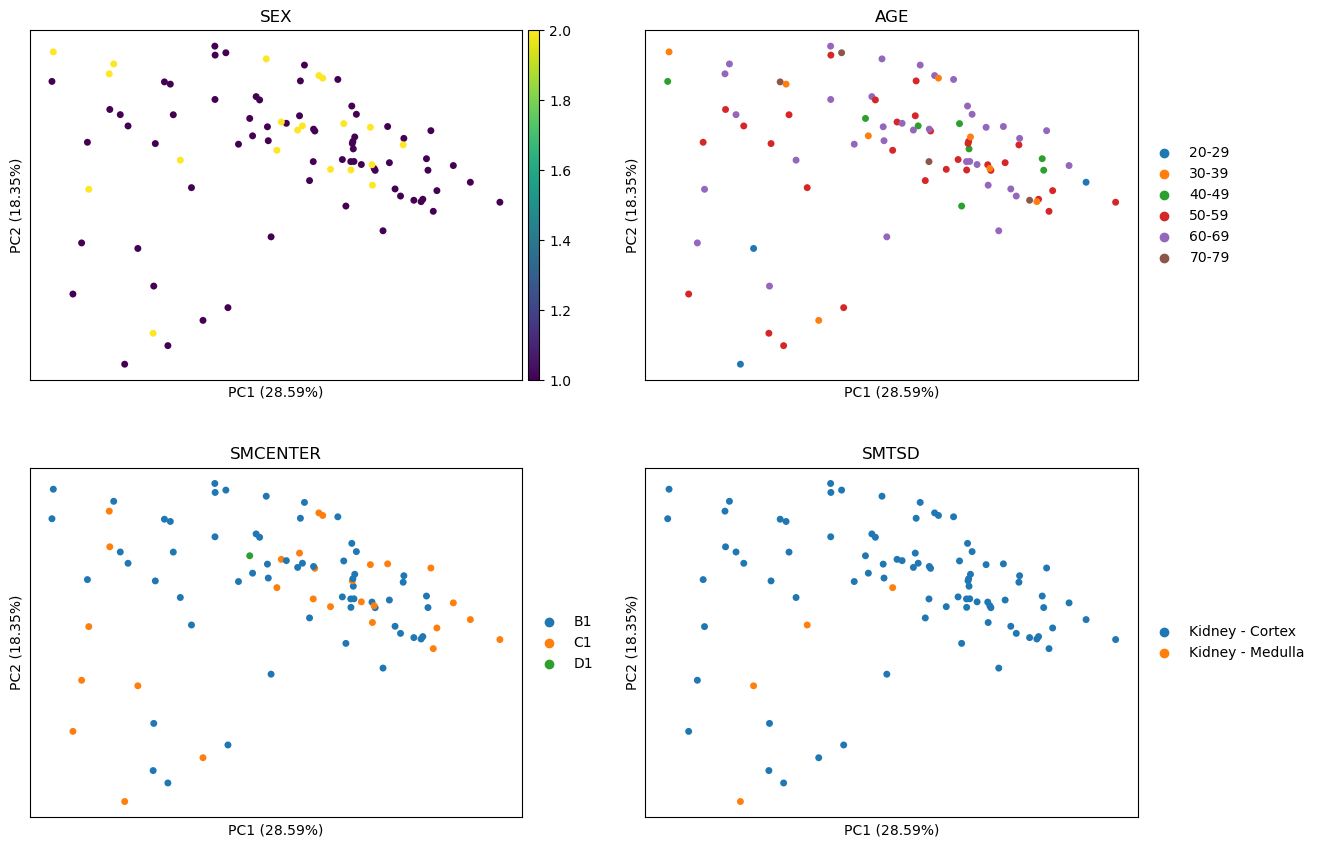

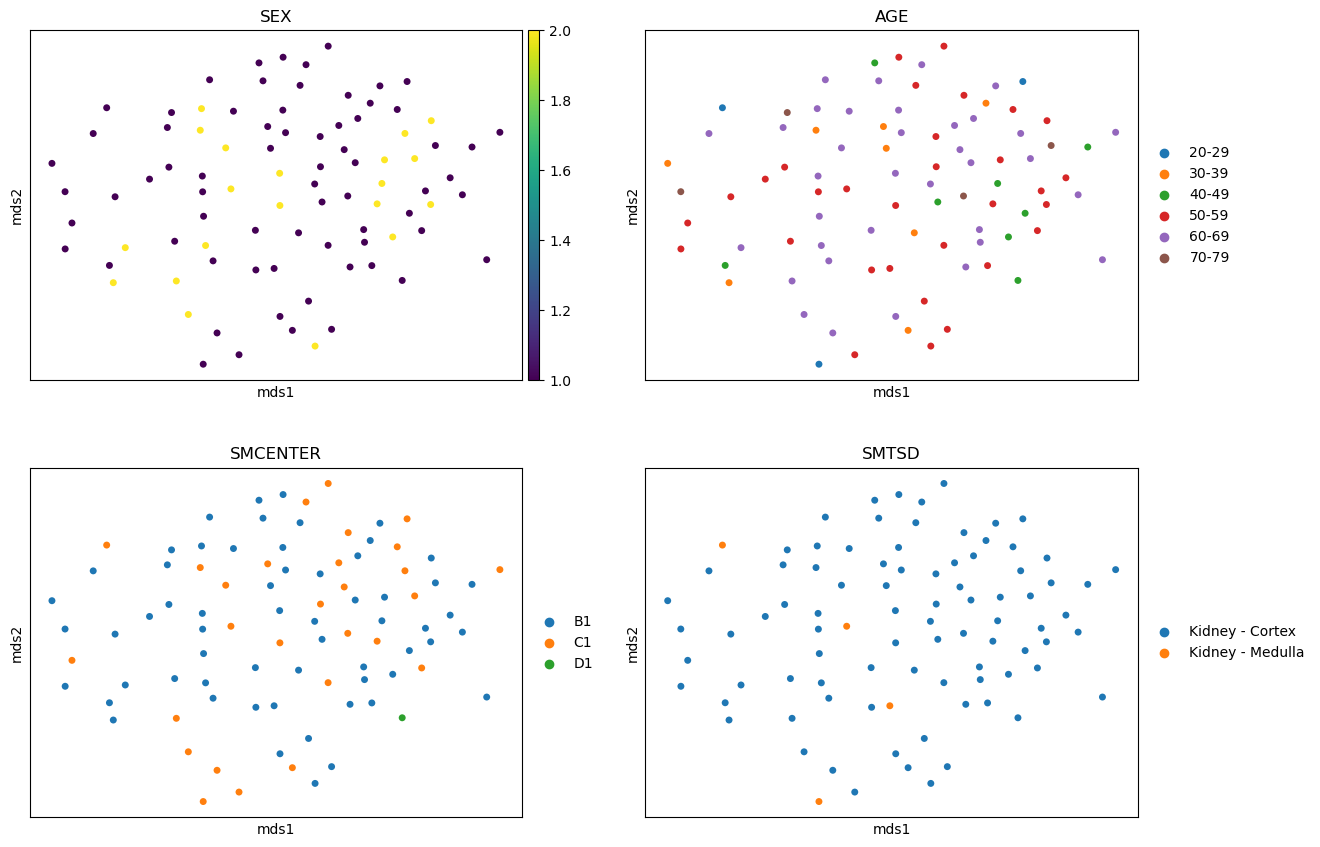

Heart


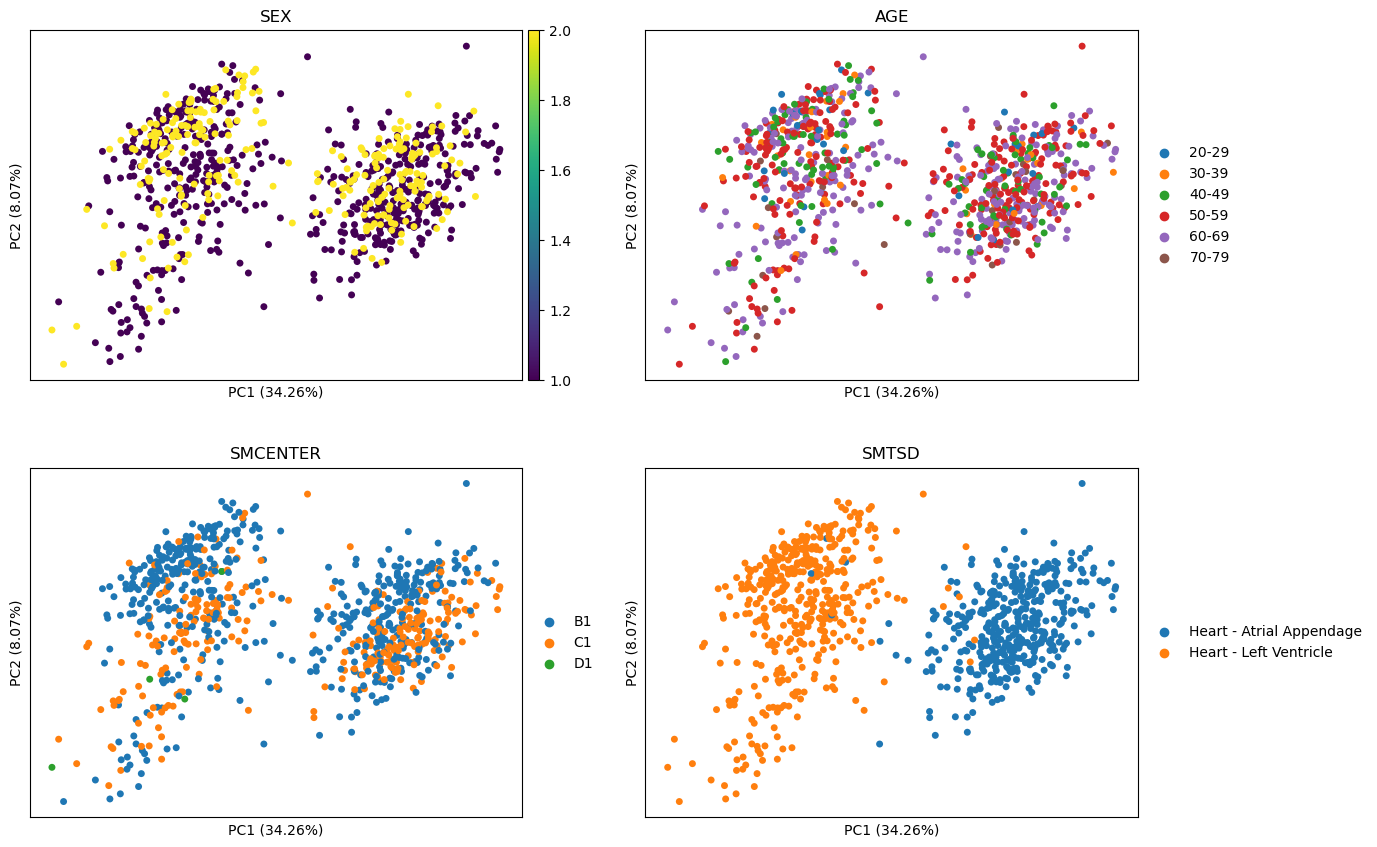

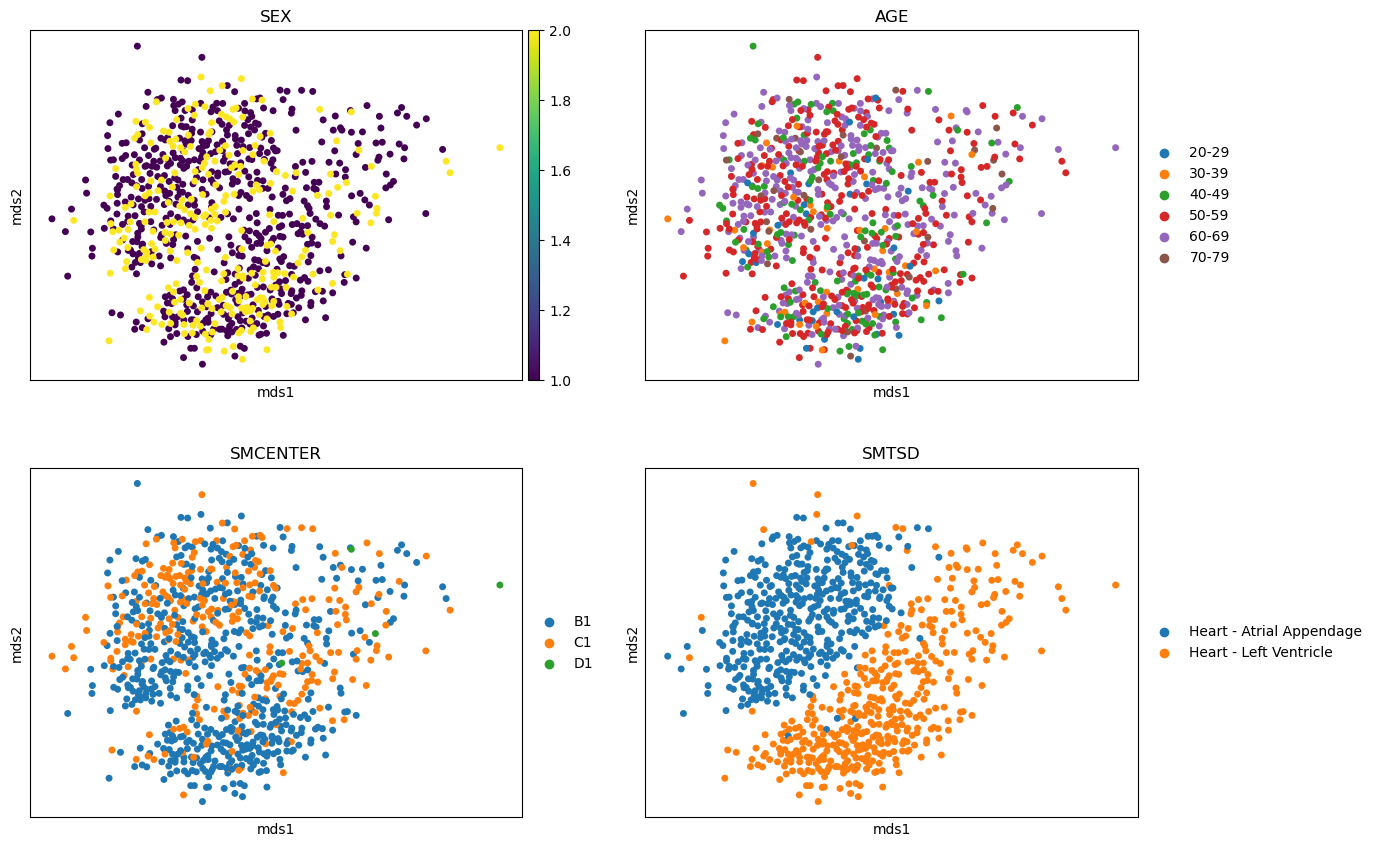

In [6]:
# We first grouped samples based on GTEx-annotated subregions (labeled SMTS) by taking, for example, all skin-derived samples. 
# We excluded the X, Y, and mitochondrial genes, identified the 1000 most variable autosomal genes, 
# and performed PCoA using Euclidean distance on the log2-transformed raw count expression data

for tissue in ['Kidney','Heart']:
    print(tissue)

    tissue_idx = adata.obs['SMTSD'].str.contains(tissue)
    genes_idx = [gene for gene in protein_coding_genes_subset['gene_id'].values if gene in adata.var_names]
    adata_tissue = adata[tissue_idx,genes_idx].copy()

    sc.pp.highly_variable_genes(adata_tissue,n_top_genes=1000,flavor='seurat_v3')
    sc.pp.log1p(adata_tissue)
    sc.pp.pca(adata_tissue)
    adata_tissue.obsm['mds'] = sklearn.manifold.MDS(verbose=1, n_jobs=4).fit_transform(adata_tissue.X)

    sc.settings.figdir=pathlib.Path('../figures')
    sc.pl.pca(adata_tissue,color=['SEX','AGE','SMCENTER','SMTSD'],annotate_var_explained=True,ncols=2,save=f'_{tissue}_subtissues.png',s=100)
    sc.pl.embedding(adata_tissue,'mds',color=['SEX','AGE','SMCENTER','SMTSD'],ncols=2,save=f'_{tissue}_subtissues.png',s=100)

### Tissue specific QC

In [ ]:
metric_names = ['log1p_total_counts','log1p_n_genes_by_counts','pct_counts_in_top_20_genes','pct_counts_mt']

adata.var["mt"] = adata.var['Description'].str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True
)

###### General QC plots
sc.set_figure_params(figsize=(10,6))
for metric_name in metric_names:
    sc.pl.violin(adata, metric_name, groupby="SMTSD_grouped",rotation=45,save=f'tissues_{metric_name}.png')

sc.set_figure_params(figsize=(6,6))
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", color="SMTSD_grouped",save='tissues_total_counts_vs_n_genes_by_counts.png')
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", color="SMTSD_grouped",save='tissues_total_counts_vs_pct_counts_mt.png')


####### Tissue specific QC
log1p_total_counts_outlier_threshold = {}
log1p_n_genes_by_counts_outlier_threshold = {}
pct_counts_in_top_20_genes_outlier_threshold = {}
mt_outlier_threshold = {}

adata.obs['outlier'] = False
for tissue in adata.obs['SMTSD_grouped'].unique():
    tissue_idx = adata.obs['SMTSD_grouped'].str.contains(tissue)
    adata_tissue = adata[tissue_idx]

    (log1p_total_counts_idx_outlier,
    log1p_total_counts_outlier_threshold[tissue]) = utils.is_outlier(adata_tissue, "log1p_total_counts", 6)

    (log1p_total_counts_idx_outlier,
    log1p_n_genes_by_counts_outlier_threshold[tissue]) = utils.is_outlier(adata_tissue, "log1p_n_genes_by_counts", 6)

    (pct_counts_in_top_20_genes_idx_outlier,
    pct_counts_in_top_20_genes_outlier_threshold[tissue]) = utils.is_outlier(adata_tissue, "pct_counts_in_top_20_genes", 6)

    (mt_idx_outlier,
    mt_outlier_threshold[tissue]) = utils.is_outlier(adata_tissue, "pct_counts_mt", 6, positive_only=True)

    adata_tissue.obs['outlier'] = (
              log1p_total_counts_idx_outlier
            | log1p_total_counts_idx_outlier
            | pct_counts_in_top_20_genes_idx_outlier
            | mt_idx_outlier
    )
    adata.obs.loc[adata_tissue.obs_names,'outlier'] = adata_tissue.obs['outlier']

    metrics = [log1p_total_counts_outlier_threshold[tissue],
               log1p_n_genes_by_counts_outlier_threshold[tissue],
               pct_counts_in_top_20_genes_outlier_threshold[tissue],
               mt_outlier_threshold[tissue]]

    f, axs = plt.subplots(2,2,figsize=(10,10))
    axs = axs.flatten()
    for i, metric_name, metric in zip(range(4),metric_names,metrics):
        
        median, threshold = metric
        sns.violinplot(data=adata_tissue.obs,y=metric_name, hue='SMTSD_grouped',ax=axs[i],legend=False)
        if metric_name == 'pct_counts_mt':
            axs[i].axhline(y=median+threshold, color='black', linestyle='--')
        else:
            axs[i].axhline(y=median+threshold, color='black', linestyle='--')
            axs[i].axhline(y=median-threshold, color='black', linestyle='--')
    plt.suptitle(tissue)
    plt.tight_layout()
    plt.savefig(f'../figures/0_{tissue}_QC.png',dpi=100,bbox_inches='tight')
    plt.show()

tissues_sample_size = adata.obs['SMTSD_grouped'].value_counts()
tissues_outlier = adata.obs['SMTSD_grouped'][adata.obs.outlier].value_counts()
tissues_outlier_percent = tissues_outlier / tissues_sample_size
plots.barplot(tissues_outlier,save_path='../figures/0_tissues_outliers.png',figsize=(12,4))
plots.barplot(tissues_outlier_percent[tissues_outlier.index],save_path='../figures/0_tissues_outliers_percent.png',figsize=(12,4))
adata_filtered = adata[~adata.obs.outlier].copy()
pd.Series(adata_filtered.obs_names).to_csv('samples_passing_outlier_QC.csv')

### Merging with GTEX QC 

Text(0.5, 1.0, 'GTEx RNA integrity number')

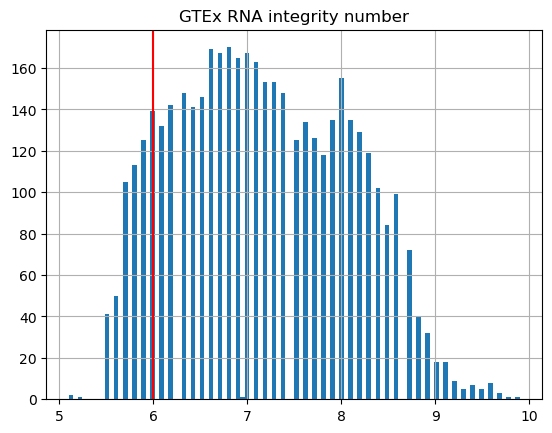

In [24]:
rnaseq_sample_selected_tissues_df['SMRIN'].hist(bins=100)
plt.axvline(6,label='threshold',c='red')
plt.title('GTEx RNA integrity number')
plt.savefig('../figures/0_RNA_integrity_number.png',dpi=100,bbox_inches='tight')